# Using TensorFlow FedAvg on Colorectal Histology dataset

In [35]:
%matplotlib inline

In [36]:
import codecs
import os
import sys
import zipfile
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import keras

# Setup
*****

This examples runs with three organizations. Two organizations provide datasets, while a third
one provides the algorithm.

In the activation following code cell, we define the different organizations needed for our FL experiment.



In [37]:
from substra import Client

N_CLIENTS = 3

# Every computation will run in `subprocess` mode, where everything runs locally in Python
# subprocesses.
# Ohers backend_types are:
# "docker" mode where computations run locally in docker containers
# "remote" mode where computations run remotely (you need to have a deployed platform for that)
client_0 = Client(backend_type="subprocess")
client_1 = Client(backend_type="subprocess")
client_2 = Client(backend_type="subprocess")
# To run in remote mode you have to also use the function `Client.login(username, password)`

clients = {
    client_0.organization_info().organization_id: client_0,
    client_1.organization_info().organization_id: client_1,
    client_2.organization_info().organization_id: client_2,
}


# Store organization IDs
ORGS_ID = list(clients.keys())
ALGO_ORG_ID = ORGS_ID[0]  # Algo provider is defined as the first organization.
DATA_PROVIDER_ORGS_ID = ORGS_ID[1:]  # Data providers orgs are the two last organizations.

# Data Preparation

This section downloads (if needed) the **histology dataset**.

In [38]:
from tf_fedavg_assets.dataset.histo_dataset import setup_histo

# Create the temporary directory for generated data
(pathlib.Path.cwd() / "tmp").mkdir(exist_ok=True)
data_path = pathlib.Path.cwd() / "tmp" / "data_histo"

setup_histo(data_path, len(DATA_PROVIDER_ORGS_ID))

# Visualizing the Dataset

# visualize dataset
images = np.load('tmp/data_histo/org_1/train/train_images.npy')
labels = np.load('tmp/data_histo/org_1/train/train_labels.npy')

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(labels[i])
plt.show()
    

min(labels), max(labels) # labels go from 0 to 7

# Dataset registration

A `documentation/concepts:Dataset` is composed of an **opener**, which is a Python script that can load
the data from the files in memory and a description markdown file.
The `documentation/concepts:Dataset` object itself does not contain the data. The proper asset that contains the
data is the **datasample asset**.

A **datasample** contains a local path to the data. A datasample can be linked to a dataset in order to add data to a
dataset.

Data privacy is a key concept for Federated Learning experiments. That is why we set
`documentation/concepts:Permissions` for `documentation/concepts:Assets` to determine how each organization can access a specific asset.

Note that metadata such as the assets' creation date and the asset owner are visible to all the organizations of a
network.

In [41]:
from substra.sdk.schemas import DatasetSpec
from substra.sdk.schemas import Permissions
from substra.sdk.schemas import DataSampleSpec

assets_directory = pathlib.Path.cwd() / "tf_fedavg_assets"
dataset_keys = {}
train_datasample_keys = {}
test_datasample_keys = {}

for i, org_id in enumerate(DATA_PROVIDER_ORGS_ID):

    client = clients[org_id]

    permissions_dataset = Permissions(public=False, authorized_ids=[ALGO_ORG_ID])

    # DatasetSpec is the specification of a dataset. It makes sure every field
    # is well defined, and that our dataset is ready to be registered.
    # The real dataset object is created in the add_dataset method.

    dataset = DatasetSpec(
        name="histo",
        type="npy",
        data_opener=assets_directory / "dataset" / "histo_opener.py",
        description=assets_directory / "dataset" / "description.md",
        permissions=permissions_dataset,
        logs_permission=permissions_dataset,
    )
    dataset_keys[org_id] = client.add_dataset(dataset)
    assert dataset_keys[org_id], "Missing dataset key"

    # Add the training data on each organization.
    # now data_sample will have keys like "images" and "labels"
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "train",
    )
    train_datasample_keys[org_id] = client.add_data_sample(data_sample)

    # Add the testing data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "test",
    )
    test_datasample_keys[org_id] = client.add_data_sample(data_sample)

# Metric registration

A metric is a function used to evaluate the performance of your model on one or several
**datasamples**.

To add a metric, you need to define a function that computes and returns a performance
from the datasamples (as returned by the opener) and the predictions_path (to be loaded within the function).

When using a TF SubstraFL algorithm, the predictions are saved in the `predict` function in numpy format
so that you can simply load them using `np.load`.

After defining the metrics, dependencies, and permissions, we use the `add_metric` function to register the metric.
This metric will be used on the test datasamples to evaluate the model performances.

In [42]:
from sklearn.metrics import accuracy_score
import numpy as np

from substrafl.dependency import Dependency
from substrafl.remote.register import add_metric

permissions_metric = Permissions(public=False, authorized_ids=[ALGO_ORG_ID] + DATA_PROVIDER_ORGS_ID)

# The Dependency object is instantiated in order to install the right libraries in
# the Python environment of each organization.
metric_deps = Dependency(pypi_dependencies=["numpy==1.23.1", "scikit-learn==1.1.1"])


def accuracy(datasamples, predictions_path):
    y_true = datasamples["labels"]
    y_pred = np.load(predictions_path)

    return accuracy_score(y_true, np.argmax(y_pred, axis=1))


metric_key = add_metric(
    client=clients[ALGO_ORG_ID],
    metric_function=accuracy,
    permissions=permissions_metric,
    dependencies=metric_deps,
)

Specify the machine learning components
***************************************
This section uses the future TF based SubstraFL API to simplify the definition of machine learning components.
However, SubstraFL is compatible with any machine learning framework.


In this section, you will:

- Register a model and its dependencies
- Specify the federated learning strategy
- Specify the training and aggregation nodes
- Specify the test nodes
- Actually run the computations

# Model definition

We choose to use a classic torch CNN as the model to train. The model structure is defined by the user independently
of SubstraFL.

In [43]:
seed = 42
tf.random.set_seed(seed)

In [44]:
class CNN(keras.Sequential):
    def __init__(self):
        super(CNN, self).__init__(layers=[
            keras.layers.Rescaling(1./255, input_shape=(150,150,3)),
            keras.layers.Conv2D(32, 5, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(64, 5, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(128, 5, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(8, activation= 'softmax')
        ])

In [45]:
model = CNN()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Specifying on how much data to train

To specify on how much data to train at each round, we use the `index_generator` object.
We specify the batch size and the number of batches to consider for each round (called `num_updates`).
See `substrafl_doc/substrafl_overview:Index Generator` for more details.

In [46]:
from substrafl.index_generator import NpIndexGenerator

# Number of model updates between each FL strategy aggregation.
NUM_UPDATES = 100

# Number of samples per update.
BATCH_SIZE = 32

index_generator = NpIndexGenerator(
    batch_size=BATCH_SIZE,
    num_updates=NUM_UPDATES,
)

# TensorFlow Dataset definition

This tf Dataset is used to preprocess the data using the `__getitem__` function.

This tf Dataset needs to have a specific `__init__` signature, that must contain (self, datasamples, is_inference).

The `__getitem__` function is expected to return (inputs, outputs) if `is_inference` is `False`, else only the inputs.
This behavior can be changed by re-writing the `_local_train` or `predict` methods.



In [47]:
img = images[0][None,...]

In [48]:
img2 = img / 255

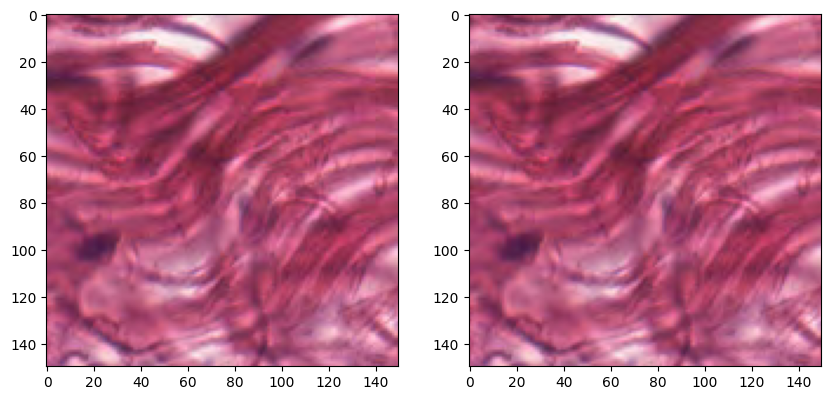

In [49]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(img2[0])
plt.show()


In [50]:
images[0][None,...].shape

(1, 150, 150, 3)

In [51]:
images[0][...].shape

(150, 150, 3)

In [52]:
images[0].shape

(150, 150, 3)

In [53]:
images2 = np.copy(images)

In [54]:
images2 = images2 / 255.

In [55]:
images

array([[[[173,  82, 113],
         [186,  95, 126],
         [213,  98, 139],
         ...,
         [213, 106, 148],
         [214, 100, 143],
         [221, 107, 150]],

        [[153,  63,  96],
         [170,  80, 113],
         [196,  90, 128],
         ...,
         [215, 109, 147],
         [224, 114, 151],
         [225, 115, 152]],

        [[134,  46,  78],
         [153,  65,  97],
         [175,  81, 115],
         ...,
         [204, 100, 133],
         [209, 106, 135],
         [200,  97, 126]],

        ...,

        [[189,  93, 141],
         [203, 107, 155],
         [192, 100, 149],
         ...,
         [195, 100, 138],
         [197,  97, 135],
         [198,  98, 136]],

        [[181,  89, 136],
         [184,  92, 139],
         [184,  98, 145],
         ...,
         [188,  98, 134],
         [184,  92, 131],
         [186,  94, 133]],

        [[184,  94, 140],
         [178,  88, 134],
         [169,  85, 134],
         ...,
         [183,  91, 128],
        

In [56]:
images2

array([[[[0.67843137, 0.32156863, 0.44313725],
         [0.72941176, 0.37254902, 0.49411765],
         [0.83529412, 0.38431373, 0.54509804],
         ...,
         [0.83529412, 0.41568627, 0.58039216],
         [0.83921569, 0.39215686, 0.56078431],
         [0.86666667, 0.41960784, 0.58823529]],

        [[0.6       , 0.24705882, 0.37647059],
         [0.66666667, 0.31372549, 0.44313725],
         [0.76862745, 0.35294118, 0.50196078],
         ...,
         [0.84313725, 0.42745098, 0.57647059],
         [0.87843137, 0.44705882, 0.59215686],
         [0.88235294, 0.45098039, 0.59607843]],

        [[0.5254902 , 0.18039216, 0.30588235],
         [0.6       , 0.25490196, 0.38039216],
         [0.68627451, 0.31764706, 0.45098039],
         ...,
         [0.8       , 0.39215686, 0.52156863],
         [0.81960784, 0.41568627, 0.52941176],
         [0.78431373, 0.38039216, 0.49411765]],

        ...,

        [[0.74117647, 0.36470588, 0.55294118],
         [0.79607843, 0.41960784, 0.60784314]

In [57]:
images[0].dtype, images2[0].dtype

(dtype('uint8'), dtype('float64'))

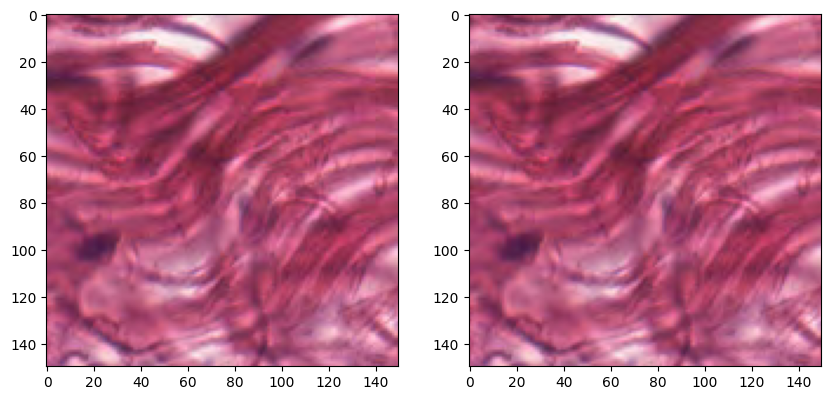

In [58]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(images2[0])
plt.show()


Normalization worked but is not visible on images, maybe a problem of cmap ?

In [59]:
class TFDataset(tf.data.Dataset):
    def __init__(self, datasamples, is_inference: bool):
        self.x = datasamples["images"] / 255. # new datasamples with normalized datas
        self.y = datasamples["labels"]
        self.is_inference = is_inference
        self.nb_classes = 8 # labels go from 0 to 7
        self.one_hots = tf.one_hot(indices=list(range(self.nb_classes)), depth=self.nb_classes, dtype='float32')
        # =
        # [[1., 0., 0., 0., 0., 0., 0., 0.],
        #  [0., 1., 0., 0., 0., 0., 0., 0.],
        #  [0., 0., 1., 0., 0., 0., 0., 0.],
        #  ...,
        # ]
        self.input_shape = self.x[0].shape # shape of input images (150,150,3)


    def __getitem__(self, idx):

        if self.is_inference:
            x = tf.convert_to_tensor(value=self.x[idx][None, ...], dtype='float64') # keep float64
            return x

        else:
            x = tf.convert_to_tensor(value=self.x[idx][None, ...], dtype='float64')
            y = self.one_hots[self.y[idx]]
            return x, y

    def __len__(self):
        return len(self.x)
    

    # adding missing methods

    def _inputs(self):
        """Returns a list of the input datasets of the dataset."""
        if self.is_inference:
            return []
        else:
            return tf.TensorSpec(shape=self.input_shape, dtype=tf.float64), tf.TensorSpec(shape=(self.nb_classes,), dtype=tf.float32)

    def element_spec(self):
        """The type specification of an element of this dataset."""
        if self.is_inference:
            return tf.TensorSpec(shape=self.input_shape, dtype=tf.float64)
        else:
            return tf.TensorSpec(shape=self.input_shape, dtype=tf.float64), tf.TensorSpec(shape=(self.nb_classes,), dtype=tf.float32)

In [60]:
# to test the previous class, we recreate a data_sample
# we assume a datasample is like
# dict('images': np.array,
#      'labels': np.array)
data_sample1 = dict(
    {
    'images': images[:10],
    'labels': labels[:10]
    }
)

In [61]:
data_sample1['images'][0].shape

(150, 150, 3)

In [62]:
test_ds = TFDataset(datasamples=data_sample1, is_inference=False)

# Test of tf_data__loader

In [63]:
# data = tf.data.Dataset.from_tensor_slices(test_ds)
# fail so tf_data_loader doesn't work atm

# SubstraFL algo definition

In [64]:
from tensorflow_algorithms.tf_fed_avg_algo import TFFedAvgAlgo


class MyAlgo(TFFedAvgAlgo):
    def __init__(self):
        super().__init__(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            index_generator=index_generator,
            dataset=TFDataset,
            seed=seed,
        )

Federated Learning strategies
=============================

A FL strategy specifies how to train a model on distributed data.
The most well known strategy is the Federated Averaging strategy: train locally a model on every organization,
then aggregate the weight updates from every organization, and then apply locally at each organization the averaged
updates.



In [65]:
from substrafl.strategies import FedAvg

strategy = FedAvg()

Where to train where to aggregate
=================================

We specify on which data we want to train our model, using the `substrafl_doc/api/nodes:TrainDataNode` object.
Here we train on the two datasets that we have registered earlier.

The `substrafl_doc/api/nodes:AggregationNode` specifies the organization on which the aggregation operation
will be computed.



In [66]:
from substrafl.nodes import TrainDataNode
from substrafl.nodes import AggregationNode


aggregation_node = AggregationNode(ALGO_ORG_ID)

train_data_nodes = list()

for org_id in DATA_PROVIDER_ORGS_ID:

    # Create the Train Data Node (or training task) and save it in a list
    train_data_node = TrainDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[train_datasample_keys[org_id]],
    )
    train_data_nodes.append(train_data_node)

Where and when to test
======================

With the same logic as the train nodes, we create `substrafl_doc/api/nodes:TestDataNode` to specify on which
data we want to test our model.

The `substrafl_doc/api/evaluation_strategy:Evaluation Strategy` defines where and at which frequency we
evaluate the model, using the given metric(s) that you registered in a previous section.



In [67]:
from substrafl.nodes import TestDataNode
from substrafl.evaluation_strategy import EvaluationStrategy


test_data_nodes = list()

for org_id in DATA_PROVIDER_ORGS_ID:

    # Create the Test Data Node (or testing task) and save it in a list
    test_data_node = TestDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        test_data_sample_keys=[test_datasample_keys[org_id]],
        metric_keys=[metric_key],
    )
    test_data_nodes.append(test_data_node)

# Test at the end of every round
my_eval_strategy = EvaluationStrategy(test_data_nodes=test_data_nodes, rounds=1)

Running the experiment
**********************

We now have all the necessary objects to launch our experiment. Please see a summary below of all the objects we created so far:

- A `documentation/references/sdk:Client` to add or retrieve the assets of our experiment, using their keys to
  identify them.
- An `TF algorithm`_ to define the training parameters *(optimizer, train
  function, predict function, etc...)*.
- A `Federated Strategy <substrafl_doc/api/strategies:Strategies>`_, to specify how to train the model on
  distributed data.
- `Train data nodes <substrafl_doc/api/nodes:TrainDataNode>`_ to indicate on which data to train.
- An `substrafl_doc/api/evaluation_strategy:Evaluation Strategy`, to define where and at which frequency we
  evaluate the model.
- An `substrafl_doc/api/nodes:AggregationNode`, to specify the organization on which the aggregation operation
  will be computed.
- The **number of rounds**, a round being defined by a local training step followed by an aggregation operation.
- An **experiment folder** to save a summary of the operation made.
- The `substrafl_doc/api/dependency:Dependency` to define the libraries on which the experiment needs to run.



In [68]:
from substrafl.experiment import execute_experiment

# A round is defined by a local training step followed by an aggregation operation
NUM_ROUNDS = 3

# The Dependency object is instantiated in order to install the right libraries in
# the Python environment of each organization.
algo_deps = Dependency(pypi_dependencies=["numpy==1.23.1", "tensorflow=2.12.0"], local_code=[pathlib.Path.cwd() / "tensorflow_algorithms"])

compute_plan = execute_experiment(
    client=clients[ALGO_ORG_ID],
    algo=MyAlgo(),
    strategy=strategy,
    train_data_nodes=train_data_nodes,
    evaluation_strategy=my_eval_strategy,
    aggregation_node=aggregation_node,
    num_rounds=NUM_ROUNDS,
    experiment_folder=str(pathlib.Path.cwd() / "tmp" / "experiment_summaries"),
    dependencies=algo_deps,
)

2023-06-21 15:44:59,051 - INFO - Building the compute plan.
INFO:substrafl.experiment:Building the compute plan.
2023-06-21 15:44:59,058 - INFO - Registering the algorithm to Substra.
INFO:substrafl.experiment:Registering the algorithm to Substra.
2023-06-21 15:45:01,903 - INFO - Registering the compute plan to Substra.
INFO:substrafl.experiment:Registering the compute plan to Substra.
2023-06-21 15:45:01,908 - INFO - Experiment summary saved to c:\Users\Jules\fichiers_git\UE22-projet-substrafl\histo_class\tmp\experiment_summaries\2023_06_21_15_45_01_0aa19bf1-f76d-4b60-8c8a-ca0420e3949e.json
INFO:substrafl.experiment:Experiment summary saved to c:\Users\Jules\fichiers_git\UE22-projet-substrafl\histo_class\tmp\experiment_summaries\2023_06_21_15_45_01_0aa19bf1-f76d-4b60-8c8a-ca0420e3949e.json


Compute plan progress:   0%|          | 0/27 [00:00<?, ?it/s]

c:\miniconda\lib\site-packages\substra\sdk\backends\local\backend.py:578: UserWarning: `transient=True` is ignored in local mode
  warnings.warn("`transient=True` is ignored in local mode")


ExecutionError: Command '['c:\\miniconda\\python.exe', 'c:\\Users\\Jules\\fichiers_git\\UE22-projet-substrafl\\histo_class\\local-worker\\tmp8dxr7qxy\\algo.py', '@c:\\Users\\Jules\\fichiers_git\\UE22-projet-substrafl\\histo_class\\local-worker\\tmp8dxr7qxy\\tmp3ql7x7ja\\arguments.txt']' returned non-zero exit status 1.

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
c:\Users\Jules\fichiers_git\UE22-projet-substrafl\histo_class\run_histo_tf.ipynb Cell 50 in ()
      6 # The Dependency object is instantiated in order to install the right libraries in
      7 # the Python environment of each organization.
      8 algo_deps = Dependency(pypi_dependencies=["numpy==1.23.1", "torch==1.11.0"])
---> 10 compute_plan = execute_experiment(
     11     client=clients[ALGO_ORG_ID],
     12     algo=MyAlgo(),
     13     strategy=strategy,
     14     train_data_nodes=train_data_nodes,
     15     evaluation_strategy=my_eval_strategy,
     16     aggregation_node=aggregation_node,
     17     num_rounds=NUM_ROUNDS,
     18     experiment_folder=str(pathlib.Path.cwd() / "tmp" / "experiment_summaries"),
     19     dependencies=algo_deps,
     20 )

File c:\miniconda\lib\site-packages\substrafl\experiment.py:336, in execute_experiment(client, algo, strategy, train_data_nodes, num_rounds, experiment_folder, aggregation_node, evaluation_strategy, dependencies, clean_models, name, additional_metadata, task_submission_batch_size)
    334 # Computation graph is created
    335 logger.info("Registering the algorithm to Substra.")
--> 336 tasks, operation_cache = _register_operations(
    337     client=client,
    338     train_data_nodes=train_data_nodes,
    339     aggregation_node=aggregation_node,
    340     evaluation_strategy=evaluation_strategy,
    341     dependencies=dependencies,
    342 )
    344 # Execute the compute plan
    345 logger.info("Registering the compute plan to Substra.")

File c:\miniconda\lib\site-packages\substrafl\experiment.py:71, in _register_operations(client, train_data_nodes, aggregation_node, evaluation_strategy, dependencies)
     68 permissions = substra.sdk.schemas.Permissions(public=False, authorized_ids=authorized_ids)
     70 for train_data_node in train_data_nodes:
---> 71     operation_cache = train_data_node.register_operations(
     72         client,
     73         permissions,
     74         cache=operation_cache,
     75         dependencies=dependencies,
     76     )
     78     tasks += train_data_node.tasks
     80 if evaluation_strategy is not None:

File c:\miniconda\lib\site-packages\substrafl\nodes\train_data_node.py:187, in TrainDataNode.register_operations(self, client, permissions, cache, dependencies)
    184 remote_struct: RemoteStruct = task["remote_operation"]
    186 if remote_struct not in cache:
--> 187     algo_key = register_algo(
    188         client=client,
    189         remote_struct=remote_struct,
    190         permissions=permissions,
    191         inputs=[
    192             schemas.AlgoInputSpec(
    193                 identifier=InputIdentifiers.datasamples,
    194                 kind=schemas.AssetKind.data_sample.value,
    195                 optional=False,
    196                 multiple=True,
    197             ),
    198             schemas.AlgoInputSpec(
    199                 identifier=InputIdentifiers.opener,
    200                 kind=schemas.AssetKind.data_manager.value,
    201                 optional=False,
    202                 multiple=False,
    203             ),
    204             schemas.AlgoInputSpec(
    205                 identifier=InputIdentifiers.local,
    206                 kind=schemas.AssetKind.model.value,
    207                 optional=True,
    208                 multiple=False,
    209             ),
    210             schemas.AlgoInputSpec(
    211                 identifier=InputIdentifiers.shared,
    212                 kind=schemas.AssetKind.model.value,
    213                 optional=True,
    214                 multiple=False,
    215             ),
    216         ],
    217         outputs=[
    218             schemas.AlgoOutputSpec(
    219                 identifier=OutputIdentifiers.local, kind=schemas.AssetKind.model.value, multiple=False
    220             ),
    221             schemas.AlgoOutputSpec(
    222                 identifier=OutputIdentifiers.shared, kind=schemas.AssetKind.model.value, multiple=False
    223             ),
    224         ],
    225         dependencies=dependencies,
    226     )
    227     cache[remote_struct] = algo_key
    228 else:

File c:\miniconda\lib\site-packages\substrafl\remote\register\register.py:303, in register_algo(client, remote_struct, permissions, inputs, outputs, dependencies)
    289 """Automatically creates the needed files to register the composite algorithm associated to the remote_struct.
    290 
    291 Args:
   (...)
    300     str: Substra algorithm key.
    301 """
    302 with tempfile.TemporaryDirectory(dir=str(Path.cwd().resolve()), prefix=TMP_SUBSTRAFL_PREFIX) as operation_dir:
--> 303     archive_path, description_path = _create_substra_algo_files(
    304         remote_struct,
    305         dependencies=dependencies,
    306         install_libraries=client.backend_mode != substra.BackendType.LOCAL_SUBPROCESS,
    307         operation_dir=Path(operation_dir),
    308     )
    309     key = client.add_algo(
    310         substra.sdk.schemas.AlgoSpec(
    311             name=remote_struct.algo_name,
   (...)
    318         )
    319     )
    320     return key

File c:\miniconda\lib\site-packages\substrafl\remote\register\register.py:190, in _create_substra_algo_files(remote_struct, install_libraries, dependencies, operation_dir)
    187 substrafl_internal = operation_dir / SUBSTRAFL_FOLDER
    188 substrafl_internal.mkdir()
--> 190 remote_struct.save(dest=substrafl_internal)
    192 # get Python version
    193 # Required to select the correct version of python inside the docker Image
    194 # Cloudpickle will crash if we don't deserialize with the same major.minor
    195 python_major_minor = ".".join(python_version().split(".")[:2])

File c:\miniconda\lib\site-packages\substrafl\remote\remote_struct.py:107, in RemoteStruct.save(self, dest)
    105 cloudpickle_path = dest / "cls_cloudpickle"
    106 with cloudpickle_path.open("wb") as f:
--> 107     cloudpickle.dump(self, f)

File c:\miniconda\lib\site-packages\cloudpickle\cloudpickle_fast.py:55, in dump(obj, file, protocol, buffer_callback)
     45 def dump(obj, file, protocol=None, buffer_callback=None):
     46     """Serialize obj as bytes streamed into file
     47 
     48     protocol defaults to cloudpickle.DEFAULT_PROTOCOL which is an alias to
   (...)
     53     compatibility with older versions of Python.
     54     """
---> 55     CloudPickler(
     56         file, protocol=protocol, buffer_callback=buffer_callback
     57     ).dump(obj)

File c:\miniconda\lib\site-packages\cloudpickle\cloudpickle_fast.py:632, in CloudPickler.dump(self, obj)
    630 def dump(self, obj):
    631     try:
--> 632         return Pickler.dump(self, obj)
    633     except RuntimeError as e:
    634         if "recursion" in e.args[0]:

TypeError: cannot pickle 'weakref' object